<a href="https://colab.research.google.com/github/JetteKA/BigData/blob/master/cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from keras.datasets import fashion_mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

In [0]:
n_clusters = 10
num_classes = 5

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [0]:
x = x_train.reshape((x_train.shape[0], -1))
x = np.divide(x, 255.)

In [0]:
x_test = x_test.reshape((x_test.shape[0], -1))
x_test = np.divide(x_test, 255.)

In [0]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')

In [0]:
cluster_distance = kmeans.fit_transform(x)

In [0]:
closest_to_centroid = cluster_distance.argsort(axis=0)[:num_classes]

In [0]:
ctc = closest_to_centroid.T

In [0]:
word_label = {0:"T-shirt/top",
              1:"Trouser",
              2:"Pullover",
              3:"Dress",
              4:"Coat",
              5:"Sandal",
              6:"Shirt",
              7:"Sneaker",
              8:"Bag",
              9:"Ankle boot"}

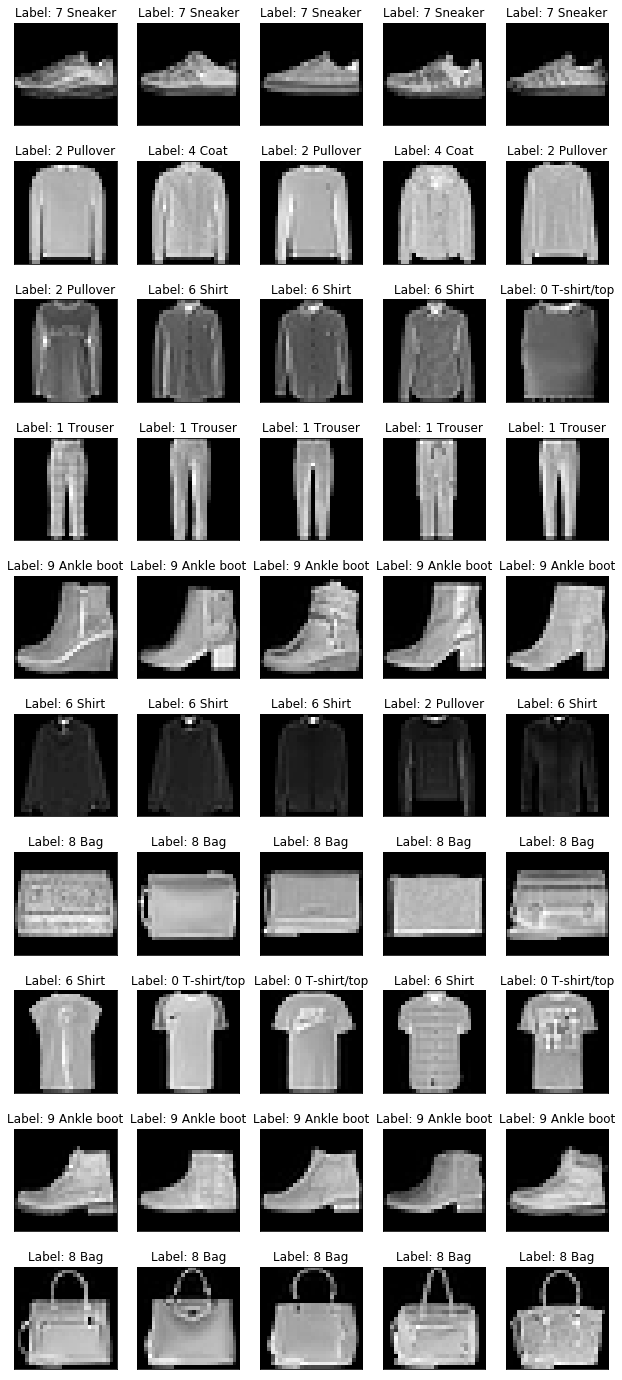

In [11]:
plt.figure(figsize = (15,25))
bottom = 0.35

x_labelled = []
y_labelled = np.empty(int(n_clusters*num_classes))
for i, index in enumerate(ctc.flatten()):

 x_labelled.append(x[index])
 y_labelled[i] = y_train[index]

 plt.subplots_adjust(bottom)
 
 plt.subplot(n_clusters,num_classes,i+1, xticks=[], yticks=[])
#  plt.set(xticks=[], yticks=[])
 plt.title('Label: {} {}'.format(y_train[index], word_label[y_train[index]]),fontsize = 12)
 plt.imshow(x[index].reshape(28, 28), cmap='gray')
 plt.savefig("5centroids_cluster.png")

In [0]:
x_labelled = np.array(x_labelled)


In [0]:
x_unlabelled = np.delete(x_train, ctc.flatten(), axis=0)
y_unlabelled = np.delete(y_train, ctc.flatten())

In [14]:
x_unlabelled[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [15]:
x_labelled[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [0]:
model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [25]:
model.fit(x_labelled, y_labelled, epochs=10)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 50 samples
Epoch 1/10
50/50 [==============================] - 1s 24ms/sample - loss: 2.2984 - acc: 0.1400
Epoch 2/10
50/50 [==============================] - 0s 313us/sample - loss: 1.6307 - acc: 0.4400
Epoch 3/10
50/50 [==============================] - 0s 127us/sample - loss: 1.3205 - acc: 0.6600
Epoch 4/10
50/50 [==============================] - 0s 154us/sample - loss: 1.1215 - acc: 0.7400
Epoch 5/10
50/50 [==============================] - 0s 145us/sample - loss: 0.9173 - acc: 0.8800
Epoch 6/10
50/50 [==============================] - 0s 133us/sample - loss: 0.7733 - acc: 0.9400
Epoch 7/10
50/50 [==============================] - 0s 96us/sample - loss: 0.6663 - acc: 0.9000
Epoch 8/10
50/50 [==============================] - 0s 105us/sample - loss: 0.5736 - acc: 0.9400
Epoch 9/10
50/50 [==============================] - 0s 107us/sample - loss: 0.5195 - acc: 0.9800
Epoch 10/10
50/50 [=========

In [0]:
x = x.reshape(60000, 28, 28)

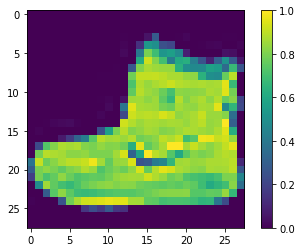

In [40]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.grid(False)
plt.show()


In [48]:
K.image_data_format()

'channels_last'

In [0]:
input_shape = (28, 28, 1)

In [0]:

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.fit(x, y_train, epochs=30)

ValueError: ignored

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)


10000/10000 - 0s - loss: 1.9138 - acc: 0.5532

Test accuracy: 0.5532


In [35]:
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 0s - loss: 0.4514 - acc: 0.8951

Test accuracy: 0.8951
